In [93]:
!mkdir models

mkdir: cannot create directory 'models': File exists


In [ ]:
!pip install datasets
!pip install lxml
!pip install torchvision 

from collections import OrderedDict
from typing import List, Tuple, Dict
import numpy as np

from datasets.utils.logging import disable_progress_bar


import torch
import torchvision.models as models
import torchvision
from torch.utils.data import DataLoader, Subset, random_split
from torchvision.transforms import (
    ToTensor,
    Normalize,
    Compose,
    Resize,
    Grayscale,
    RandomHorizontalFlip,
    RandomRotation,
)
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.datasets import CIFAR10, MNIST, FashionMNIST
import torch.nn as nn
import torch.nn.functional as F
import csv
import copy

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.manifold import MDS  # Optional for visualization

import xml.etree.ElementTree as ET
from lxml import etree

import random
import matplotlib.pyplot as plt

import logging
from datetime import datetime
import shutil
import os

log_path = datetime.now().strftime("%Y-%m-%d_%H-%M-%S_")
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

log_file = log_path + '.log'
os.mkdir(log_path)
open(log_file, 'a').close()

model_type = "resnet"
dataset_type = "cifar"
num_classes=10

# **Load XML File**

In [94]:
def parse_xml_assignments(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    node_assignments = {}
    for node in root.findall('Node'):
        node_id = int(node.get('id'))
        shards = [(int(dp.get('classLabel')), int(dp.get('shard'))) for dp in node.findall('DataPair')]
        node_assignments[node_id] = shards
    return node_assignments

# from google.colab import files
# uploaded = files.upload()

# **Non-IID Distribution**

In [95]:
class Net(nn.Module):
    def __init__(self, num_classes=10, model_type="cnn", dataset_type="cifar"):
        super(Net, self).__init__()
        self.model_type = model_type

        if self.model_type == "resnet":
            self.resnet18 = models.resnet18(pretrained=False)
            if dataset_type == "mnist":
                # Required for MNIST dataset since it only has one channel instead of 3
                self.resnet18.conv1 = nn.Conv2d(
                    1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
                )
            # Replace the fully connected layer to match the number of classes
            self.resnet18.fc = nn.Linear(self.resnet18.fc.in_features, num_classes)

        elif self.model_type == "cnn":
            self.conv1 = nn.Conv2d(3, 6, 5)
            self.pool = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(6, 16, 5)
            self.fc1 = nn.Linear(16 * 5 * 5, 120)
            self.fc2 = nn.Linear(120, 84)
            self.fc3 = nn.Linear(84, 10)

        elif self.model_type == "vgg":
            self.vgg16 = models.vgg16(pretrained=False)
            # Replace the last fully connected layer to match the number of classes
            self.vgg16.classifier[6] = nn.Linear(4096, num_classes)

        else:
            print("No valid model given")

    def forward(self, x):
        out = None
        if self.model_type == "resnet":
            out = self.resnet18(x)
        elif self.model_type == "cnn":
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = x.view(-1, 16 * 5 * 5)
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            out = x
        elif self.model_type == "vgg":
            out = self.vgg16(x)
        else:
            print("No valid model given")
        return out

In [96]:
class Dataset:
    def __init__(self, model_type=""):
        self.num_classes = 10
        self.num_shards_per_class = 4
        self.transform = self._get_transform(model_type)

    def _get_transform(self, model_type):
        if model_type == "vgg":
            return transforms.Compose([
                transforms.Resize((224, 224)), 
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ])
        elif model_type == "resnet":
            return transforms.Compose([
                transforms.Resize((150, 150)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ColorJitter(0.3, 0.4, 0.4, 0.2),
                transforms.ToTensor(),
                transforms.Normalize((0.425, 0.415, 0.405), (0.205, 0.205, 0.205))
            ])
        else:
            return transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])

    def load_CIFAR10_dataset(self):
        train = datasets.CIFAR10(root="./data", train=True, download=True, transform=self.transform)
        test = datasets.CIFAR10(root="./data", train=False, download=True, transform=self.transform)
        return train, test

    def load_MNIST_dataset(self):
        train = datasets.MNIST(root="./data", train=True, download=True, transform=self.transform)
        test = datasets.MNIST(root="./data", train=False, download=True, transform=self.transform)
        return train, test

    def load_FashionMNIST_dataset(self):
        train = datasets.FashionMNIST(root="./data", train=True, download=True, transform=self.transform)
        test = datasets.FashionMNIST(root="./data", train=False, download=True, transform=self.transform)
        return train, test

    def load_shards_from_xml_file(self, xml_file, train, test, num_clients):
        node_assignments = parse_xml_assignments(xml_file)
        train_data_indices = {i: np.array([], dtype="int64") for i in range(num_clients)}
        test_data_indices = {i: np.array([], dtype="int64") for i in range(num_clients)}
        train_shards, _ = self.divide_class_into_shards(train, 10, 20)
        test_shards, _ = self.divide_class_into_shards(test, 10, 20)

        trainLoaders, testLoaders = [], []

        for node in range(num_clients):
            shard_ids = node_assignments[node]
            indices_tr = [(shard_id[0] - 1) * 20 + shard_id[1] for shard_id in shard_ids]
            indices_ts = [(shard_id[0] - 1) * 20 + random.randint(1, 19) for shard_id in shard_ids]
            train_indices = np.concatenate([train_shards[idx] for idx in indices_tr])
            test_indices = np.concatenate([test_shards[idx] for idx in indices_ts])

            train_loader = DataLoader(Subset(train, train_indices), batch_size=64, shuffle=True)
            test_loader = DataLoader(Subset(test, test_indices), batch_size=64, shuffle=True)

            trainLoaders.append(train_loader)
            testLoaders.append(test_loader)

        return trainLoaders, testLoaders

    def divide_class_into_shards(self, dataset, num_classes: int, num_shards_per_class: int):
        num_shards = num_classes * num_shards_per_class
        num_imgs = int(len(dataset) / num_shards_per_class / num_classes)
        class_indices = [[] for _ in range(num_classes)]
        labels = np.array(dataset.targets)

        for idx, label in enumerate(labels):
            class_indices[label].append(idx)
        
        for i in range(num_classes):
            np.random.shuffle(class_indices[i])

        shards = [class_indices[i][j * num_imgs: (j + 1) * num_imgs] for i in range(num_classes) for j in range(num_shards_per_class)]
        return np.array(shards, dtype="object"), num_shards

    def noniid_split(self, dataset, num_classes: int, num_clients: int, num_shards_per_class: int):
        shards, num_shards = self.divide_class_into_shards(dataset, num_classes, num_shards_per_class)
        client_data_indices = {i: np.array([], dtype="int64") for i in range(num_clients)}
        shards_per_client = 4
        shards_assignments = np.zeros(num_shards, dtype=bool)
        classes = []

        for client in range(num_clients):
            assigned_shards = []
            classes_assigned = []

            while len(assigned_shards) < shards_per_client:
                shard_idx = np.random.choice(np.where(shards_assignments == False)[0])
                class_idx = shard_idx // num_shards_per_class
                if class_idx not in classes_assigned:
                    assigned_shards.append(shard_idx)
                    classes_assigned.append(class_idx)
                    shards_assignments[shard_idx] = True
            
            classes.append(classes_assigned)

            for shard in assigned_shards:
                client_data_indices[client] = np.concatenate((client_data_indices[client], shards[shard]), axis=0)

        return client_data_indices, classes

    def partition_test_data_based_on_train(self, dataset, train_idx, num_classes: int, num_clients: int, num_shards_per_class: int):
        shards, num_shards = self.divide_class_into_shards(dataset, num_classes, num_shards_per_class)
        client_data_indices = {i: np.array([], dtype="int64") for i in range(num_clients)}
        shards_per_client = 4
        classes = []

        for client in range(num_clients):
            assigned_shards = []
            classes_assigned = []

            while len(assigned_shards) < shards_per_client:
                class_idx = train_idx[client][len(assigned_shards)]
                shard_idx = class_idx * 20 + random.randint(1, 19)
                assigned_shards.append(shard_idx)
                classes_assigned.append(class_idx)

            classes.append(classes_assigned)

            for shard in assigned_shards:
                client_data_indices[client] = np.concatenate((client_data_indices[client], shards[shard]), axis=0)

        return client_data_indices

    def get_dataloaders(self, dataset, indices, batch_size):
        loaders = []
        for client_idx in indices:
            subset = Subset(dataset, indices[client_idx])
            loader = DataLoader(subset, batch_size=batch_size, shuffle=True)
            loaders.append(loader)
        return loaders


# Models

In [97]:
class Net(nn.Module):
    def __init__(self, num_classes=10, model_type="cnn", dataset_type="cifar"):
        super(Net, self).__init__()
        self.model_type = model_type
        
        if self.model_type == "resnet":
            self.resnet18 = models.resnet18(pretrained=False)
            if dataset_type == "mnist":
                # Required for MNIST dataset since it only has one channel instead of 3
                self.resnet18.conv1 = nn.Conv2d(
                    1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
                )
            # Replace the fully connected layer to match the number of classes
            self.resnet18.fc = nn.Linear(self.resnet18.fc.in_features, num_classes)
            self.resnet18.to(DEVICE)
        
        elif self.model_type == "cnn":
            self.conv1 = nn.Conv2d(3, 6, 5)
            self.pool = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(6, 16, 5)
            self.fc1 = nn.Linear(16 * 5 * 5, 120)
            self.fc2 = nn.Linear(120, 84)
            self.fc3 = nn.Linear(84, 10)
            self.to(DEVICE)
        
        elif self.model_type == "vgg":
            self.vgg16 = models.vgg16(pretrained=False)
            # Replace the last fully connected layer to match the number of classes
            self.vgg16.classifier[6] = nn.Linear(4096, num_classes)
            self.vgg16.to(DEVICE)
        
        else:
            print("No valid model given")

    def forward(self, x):
        x = x.to(DEVICE)  # Move input data to the device
        out = None
        
        if self.model_type == "resnet":
            out = self.resnet18(x)
        elif self.model_type == "cnn":
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = x.view(-1, 16 * 5 * 5)
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            out = x
        elif self.model_type == "vgg":
            out = self.vgg16(x)
        else:
            print("No valid model given")
        
        return out


# **Client**

In [98]:
def calculate_accuracy(loader, model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


def train(net, node_id, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(net.parameters())

    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            """
            if isinstance(outputs, tuple):
              outputs, aux1, aux2 = outputs
              loss = criterion(outputs, labels) + 0.3 * criterion(aux1, labels) + 0.3 * criterion(aux2, labels)
            else:
              loss = criterion(outputs, labels)
            """
            ## no logits
            ## For googlenet model
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            ## outputs.data
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
    loss /= len(trainloader.dataset)
    acc = correct / total

    model_path = f"models/node_{node_id}.pth"
    torch.save(net.state_dict(), model_path)

    return acc, loss


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            ## For googlenet model
            """
            if isinstance(outputs, tuple):
              outputs, _, _ = outputs
            """
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    # print(f" test loss {loss}, accuracy {accuracy}")
    return accuracy, loss


class Client:
    def __init__(self, net, node_id, trainloader, testloader):
        self.net = net
        self.trainloader = trainloader
        self.testloader = testloader
        self.node_id = node_id
        self.train_acc, self.test_acc = 0.0, 0.0
        self.global_net = Net(num_classes, model_type, dataset_type)

    # def train_test(self):
    #     self.train_acc,_=
    #     self.test_acc

    def set_bias(self, pref, bias):
        self.bias = bias
        self.pref = pref

    def set_shard(self, shard):
        self.shard = shard

    def get_global_net(self):
        return self.global_net

    def setting_parameters(self, parameters: List[np.ndarray]):
        params_dict = zip(self.net.state_dict().items(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        self.net.load_state_dict(state_dict, strict=True)

    def getting_parameters(self) -> List[np.ndarray]:
        return [val.cpu().numpy() for _, val in self.net.state_dict().items()]

    # def get_parameters(self):
    # return getting_parameters()

    def fit(self, parameters):
        self.setting_parameters(parameters)
        train(self.net, self.node_id, self.trainloader, epochs=1)
        return self.getting_parameters(), len(self.trainloader), {}

    def evaluate(self, parameters):
        self.setting_parameters(parameters)
        loss, accuracy = test(self.net, self.testloader)
        return float(loss), len(self.testloader), {"accuracy": float(accuracy)}

    def Train_test_and_return_acc(self):
        self.train_acc, _ = train(self.net, self.node_id, self.trainloader, 1)
        self.test_acc, _ = test(self.net, self.testloader)
        return self.train_acc, self.test_acc

# **Server**

In [99]:
def divide_nested_list(nested_list, divisor):
    for i in range(len(nested_list)):
        if isinstance(nested_list[i], list):
            divide_nested_list(nested_list[i], divisor)
        else:
            nested_list[i] /= divisor
    return nested_list


def zero_nested_list(nested_list):
    for i in range(len(nested_list)):
        if isinstance(nested_list[i], list):
            zero_nested_list(nested_list[i])
        else:
            nested_list[i] = 0
    return nested_list


class Server:
    def __init__(self):
        self.models = []

    def append_model(self, model: nn.Module):
        if not isinstance(model, nn.Module):
            raise TypeError("Only instances of nn.Module can be appended")
        self.models.append(model)

    def aggregate(self):
        if not self.models:
            raise ValueError("No models added to the server.")
        print("model numbers:", len(self.models))
        # Initialize a model with the same architecture to store the average weights
        # avg_model = Net(num_classes=10)
        avg_model = Net(num_classes, model_type, dataset_type)

        # Iterate over each parameter in the average model
        with torch.no_grad():
            for param_name, avg_param in avg_model.named_parameters():
                # Sum the corresponding parameters from all models
                temp = torch.zeros_like(avg_param)
                for model in self.models:
                    model_param = dict(model.named_parameters())[param_name]
                    temp += model_param.data
                # Divide by the number of models to get the average
                avg_param.copy_(temp / len(self.models))

        return avg_model

# **Clustering**

In [100]:
def find_num_cluster(clusters):
    num_cluster = []
    for item in clusters:
        if item not in num_cluster:
            num_cluster.append(item)
    return len(num_cluster)

class Clustering:
    def __init__(self, clients, trainLoaders, percentage, Cluster_number):
        self.clients = clients
        self.num_nodes = len(clients)
        self.percentage = percentage
        self.Mask_Number = 0
        self.maskIds = []
        self.grads = []
        self.load_and_claculate_sensitivity(trainLoaders)
        self.Cluster_number = Cluster_number
        self.distances = self.calculate_distance()
        self.Clusters = self.Make_Clusters()

    def assign_save_ids_to_weights(self, model):
        weight_id_map = {}
        weight_id = 0
        for name, parameter in model.named_parameters():
            if "bias" not in name and parameter.requires_grad:
                weight_id_map[name] = {}
                num_weights = parameter.numel()
                for i in range(num_weights):
                    weight_id_map[name][i] = weight_id
                    weight_id += 1
        # Save weight_id_map as required
        return weight_id_map

    def load_and_claculate_sensitivity(self, trainLoaders):
        for cid in self.clients:
            model = load_torch_model(cid).to(DEVICE)
            sensitivity_value = self.calculate_sensitivity(model, trainLoaders[int(cid)])
            gradients = [weight for weight in sensitivity_value.values()]
            weight_id_map = self.assign_save_ids_to_weights(load_torch_model(0))
            mask_ID, weights = self.get_maskIds(sensitivity_value, weight_id_map)
            self.maskIds.append(mask_ID)
            self.grads.append(weights)

    def calculate_sensitivity(self, model, dataloader):
        model.train()
        criterion = nn.CrossEntropyLoss()
        gradient_sums = {name: 0.0 for name, param in model.named_parameters() if "bias" not in name}

        for inputs, labels in dataloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            model.zero_grad()
            loss.backward()

            sensitivities = {}
            for name, parameter in model.named_parameters():
                if "bias" not in name and parameter.requires_grad:
                    grads = parameter.grad.abs().view(-1).cpu().numpy()
                    for i, grad in enumerate(grads):
                        sensitivities[(name, i)] = grad
        return sensitivities

    def get_maskIds(self, sensitivity_values_node, weight_id_map):
        num_weights = len(sensitivity_values_node)
        top_k = int(np.ceil(self.percentage * num_weights / 100))
        self.Mask_Number = top_k
        sorted_weights = sorted(sensitivity_values_node.items(), key=lambda item: item[1], reverse=True)[:top_k]
        weights = [weight for (layer, index), weight in sensitivity_values_node.items()]
        top_weight_ids = [weight_id_map[layer][index] for (layer, index), _ in sorted_weights]
        return top_weight_ids, weights

    def normalize_distance(self, distances):
        min1 = np.min(np.ma.masked_equal(distances, 0))
        max1 = np.max(np.ma.masked_equal(distances, 0))
        normal_distances = np.zeros((self.num_nodes, self.num_nodes))
        for i in range(self.num_nodes):
            normal_distances[i][i] = 0
            for j in range(i + 1, self.num_nodes):
                normal_distances[i][j] = normal_distances[j][i] = (distances[i][j] - min1) / (max1 - min1)
        return normal_distances

    def normalize(self, distances, sensitive):
        normal_distances = np.zeros((self.num_nodes, self.num_nodes))
        for i in range(self.num_nodes):
            normal_distances[i][i] = 0
            for j in range(i + 1, self.num_nodes):
                normal_distances[i][j] = normal_distances[j][i] = distances[i][j] / len(sensitive)
        return normal_distances

    def calculate_common_ids(self, index1, index2):
        sarr1 = set(self.maskIds[index1])
        sarr2 = set(self.maskIds[index2])
        inter = sarr1.intersection(sarr2)
        return len(inter)

    def cosine_similarity(self, index1, index2):
        dot_product = 0.0
        norm1 = 0.0
        norm2 = 0.0
        arr1 = self.maskIds[index1]
        arr2 = self.maskIds[index2]
        for i in range(len(self.maskIds)):
            dot_product += (arr1[i] * arr2[i]).sum().item()
            norm1 += (arr1[i] ** 2).sum().item()
            norm2 += (arr2[i] ** 2).sum().item()
        if norm1 == 0 or norm2 == 0:
            return 0
        return dot_product / (np.sqrt(norm1) * np.sqrt(norm2))

    def calculate_distance(self):
        similarity_matrix = np.zeros((self.num_nodes, self.num_nodes))
        for i in range(self.num_nodes):
            for j in range(i + 1, self.num_nodes):
                similarity = self.calculate_common_ids(i, j)
                similarity_matrix[i, j] = similarity
                similarity_matrix[j, i] = similarity
            similarity_matrix[i, i] = self.Mask_Number
        distances = self.Mask_Number - similarity_matrix
        return distances

    def index_to_value(self, groups):
        value_groups = []
        for group in groups:
            value_groups.append([self.clients[index] for index in group])
        return value_groups

    def Make_Clusters(self):
        normal_distances = (self.distances + self.distances.T) / 2
        np.fill_diagonal(normal_distances, 0)
        affinity_propagation = AffinityPropagation(affinity="precomputed")
        normal_distances = -normal_distances
        clusters = affinity_propagation.fit_predict(normal_distances)
        max_label = max(clusters)
        noise_indices = clusters == -1
        unique_noise_labels = np.arange(max_label + 1, max_label + 1 + np.sum(noise_indices))
        clusters[noise_indices] = unique_noise_labels
        cluster_list = [np.where(clusters == cluster_id)[0].tolist() for cluster_id in range(find_num_cluster(clusters))]
        cluster_list = self.index_to_value(cluster_list)
        return cluster_list


# **FL**

In [101]:
class FL:

    def __init__(
        self,
        clients,
        client_initial_models,
        round_number,
        trainloaders,
        testloaders,
        Sensitivity_percentage,
    ):
        self.clients = clients
        self.num_clients = len(clients)
        self.client_initial_models = client_initial_models
        self.Sensitivity_percentage = Sensitivity_percentage
        self.trainloaders = trainloaders
        self.testloaders = testloaders
        self.round_number = round_number
        self.global_model = None
        self.clustering_result = None
        self.client_obj_list = []
        self.accuracies = {}
        self.training()

    def training(self):
        # print("-----------FL class->training")
        # print("len clients", len(self.clients))
        # print("len models", len(self.client_initial_models))
        for cid in self.clients:
            print("cid is:", cid)
            # print("trainloader", len(self.trainloaders))
            client = Client(
                self.client_initial_models[self.clients.index(int(cid))],
                cid,
                self.trainloaders[int(cid)],
                self.testloaders[int(cid)],
            )
            self.client_obj_list.append(client)

        global_model = Net(num_classes, model_type, dataset_type)

        os.makedirs("models", exist_ok=True)
        # c = {key: torch.zeros_like(val) for key, val in global_model.state_dict().items()}
        # client_controls = [{key: torch.zeros_like(val) for key, val in global_model.state_dict().items()} for _ in range(len(self.clients))]

        start_time = datetime.now()
        for r in range(self.round_number):
            print(f"\nRound {r+1}/{self.round_number}")
            server = Server()
            global_accuracy = 0

            index = 0
            for cid in self.clients:
                # self.client_obj_list[cid].net=copy.deepcopy(global_model)
                # self.client_obj_list[cid]=client

                # client.setting_parameters(global_model)
                train_acc, test_acc = self.client_obj_list[
                    self.clients.index(cid)
                ].Train_test_and_return_acc()
                # train_acc, test_acc = self.client_obj_list[self.clients.index(cid)].train_and_test_fedprox(global_model)
                # train_acc, test_acc, c = self.client_obj_list[self.clients.index(cid)].train_and_test_scaffold(global_model, client_controls[cid], c)
                print(f"node {cid}: train_acc: {train_acc}, test_acc:{test_acc}")
                with open(log_file, "a") as f:
                    f.write(
                        f"\nNode {cid} - Round {r+1}: Train Accuracy: {train_acc}%, Test Accuracy: {test_acc}%"
                    )
                global_accuracy += test_acc
                self.accuracies[r + 1] = global_accuracy
                server.append_model(self.client_obj_list[self.clients.index(cid)].net)

            global_model = server.aggregate()

            # global_model = server.aggregate_prox(global_model)
            end_time = datetime.now()
            execution_time = end_time - start_time
            print("time", execution_time)
            with open(log_file, "a") as f:
                f.write(f"\n Exe FL Round Time: {execution_time}")
            # global_model, c = server.aggregate_scaffold(global_model, client_controls, c)
            print("global acc:", global_accuracy / self.num_clients)
            with open(log_file, "a") as f:
                f.write(
                    f"\nGlobal Model of {self.num_clients}- Round {r+1}: Test Accuracy is: {global_accuracy/self.num_clients}%"
                )
            for cid in self.clients:
                self.client_obj_list[self.clients.index(cid)].net = copy.deepcopy(
                    global_model
                )

        # filtered_c =  [sublist for sublist in c if sublist]
        self.global_model = global_model

# Visualization

In [102]:
class Visualizer:
    def __init__(self, trainloaders):
        self.trainloaders = trainloaders

    def count_classes(self):
        # Initialize a list to store class counts for each DataLoader
        class_counts = []
        # CIFAR-10 has 10 classes, indexed 0-9
        for loader in self.trainloaders:
            # Initialize counts for this DataLoader
            counts = np.zeros(10, dtype=int)
            # Iterate through all batches in the DataLoader
            for _, labels in loader:
                # Count occurrences of each class in this batch and add to counts
                for label in labels:
                    counts[label] += 1
            class_counts.append(counts)
        return class_counts

    def plot_class_distribution(self):
        class_counts = self.count_classes()
        num_classes = 10
        labels = [
            "airplane",
            "automobile",
            "bird",
            "cat",
            "deer",
            "dog",
            "frog",
            "horse",
            "ship",
            "truck",
        ]
        labels.reverse()
        num_nodes = len(class_counts)

        fig, ax = plt.subplots(figsize=(9, 5))
        width = 0.35  # the width of the bars

        # Create an array with the positions of each bar along the x-axis
        x = np.arange(num_classes)

        # Plot data
        for i in range(num_nodes):
            # Compute the bottom positions for the stacked bars
            bottom = (
                np.sum(class_counts[:i], axis=0) if i > 0 else np.zeros(num_classes)
            )
            ax.bar(x, class_counts[i], width, bottom=bottom, label=f"Client {i+1}")

        ax.set_xlabel("Classes")
        ax.set_ylabel("Number of Samples")
        ax.set_title("Distribution of CIFAR-10 Classes Across Different Nodes")
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.legend(title="Node")

        plt.show()

    # Example usage

# **Load & Save Model**

In [103]:
def load_torch_model(node_id):
    model_path = f"models/node_{node_id}.pth"
    model = torch.load(model_path)
    return model


def save_torch_model(model, node_id):
    model_path = f"models/node_{node_id}.pth"
    torch.save(model, model_path)


def save_model_param(model, node_id, round_number):
    model_path = f"models/node_{node_id}_round_{round_number}.pth"
    torch.save(model.state_dict(), model_path)

In [104]:
def load_and_prepare_data():

    # c = ClusteredDataset()
    # trainloaders = c.get_loaders(60000, 600, 200, 2, train=True)
    # testloaders = c.get_loaders(10000, 200, 100, 2, train=False)
    # trainloaders, testloaders = get_loaders(10)
    # print(len(trainloaders) , len(testloaders))
    dataset = Dataset(model_type)
    train_data, test_data = dataset.load_CIFAR10_dataset()
    # train_data, test_data = dataset.load_MNIST_dataset()
    # train_data, test_data = dataset.load_FashionMNIST_dataset()

    # print("data", len(train_data), len(test_data))
    # train_indices , train_idx = dataset.noniid_split(train_data, num_classes, num_clients, num_shards_per_class)
    # test_indices = dataset.partition_test_data_based_on_train(test_data, train_idx, num_classes, num_clients, num_shards_per_class)

    # trainloaders = dataset.get_dataloaders(train_data, train_indices, 32)
    # testloaders = dataset.get_dataloaders(test_data, test_indices, 32)
    trainloaders, testloaders = dataset.load_shards_from_xml_file(
        "/kaggle/input/fl-shards/shards.xml", train_data, test_data, 10
    )
    print("final ", len(trainloaders), len(testloaders))
    """
    for node_id in range(num_clients):

        data_path = f'./data/train_node_{node_id}_data.pth'
        torch.save(trainloaders[node_id], data_path)

        data_path = f'./data/test_node_{node_id}_data.pth'
        torch.save(testloaders[node_id], data_path)
    """

    print("done saving")
    return trainloaders, testloaders

# **Define Parameters**

In [105]:
num_shards_per_class = 20
num_clients = 10
num_classes=10
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Clustering_method="Mask"# Weight, Mask
Clustering_period = 5
cluster_number=3
Round_Epochs = 1
#Node_numbers = 50
FL_rounds = 6
Sensitivity_percentage = 10


In [106]:
trainloaders,testloaders=load_and_prepare_data()

Files already downloaded and verified
Files already downloaded and verified
final  10 10
done saving


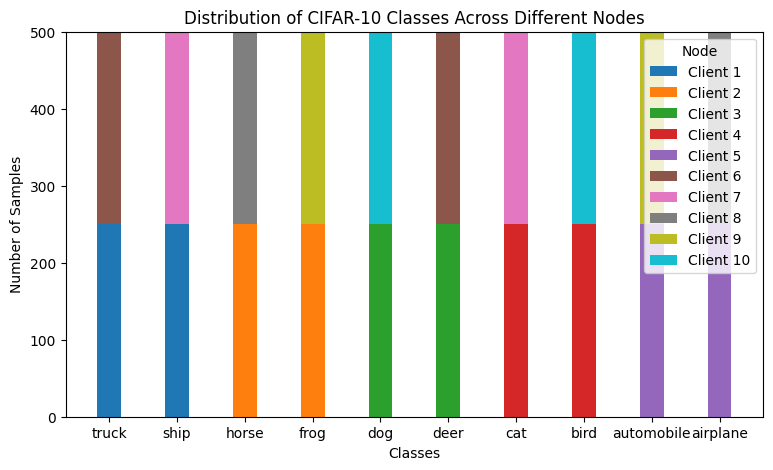

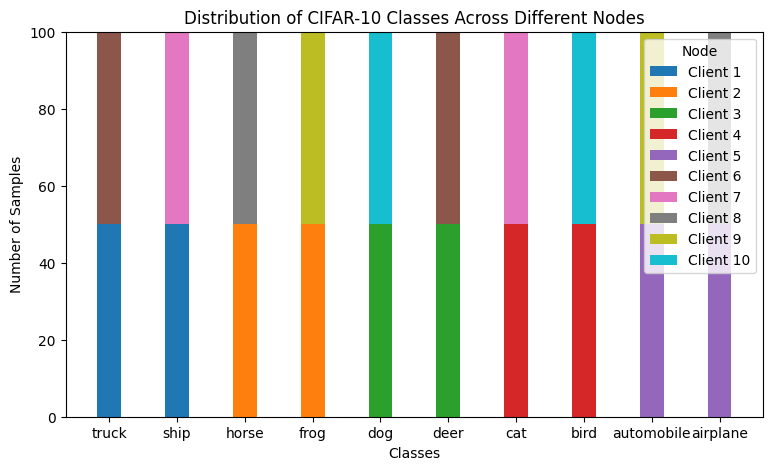

In [107]:
Visualizer(trainloaders).plot_class_distribution()
Visualizer(testloaders).plot_class_distribution()

# **Run**

In [ ]:
clusters = []

initial = [i for i in range(num_clients)]
clusters.append(initial)


# client_IDs=[6,4,2,1,3]
def generate_initial_models(step, cluster, client_IDs, client_Models):
    print("-------------in initial genertaio")
    print("cluster", cluster)
    print("clientIDs", client_IDs)
    print("len_client_models(should be 10):", len(client_Models))
    list1 = []
    if step == 0:
        for member in range(len(cluster)):
            list1.append(Net(num_classes, model_type, dataset_type))
    else:
        for index in cluster:
            list1.append(client_Models[client_IDs.index(index)])
    return list1


## ---------------main
client_Models = []
client_copy_models = []

for step in range(Clustering_period):
    client_copy_models = copy.deepcopy(client_Models)
    client_Models = []
    print("\n\n---------Clustering step", step)
    FL_list = []
    client_IDs = []
    for cluster in clusters:
        for Id in cluster:
            client_IDs.append(Id)

        cluster_initial_models = generate_initial_models(
            step, cluster, client_IDs, client_copy_models
        )
        print(
            " ---in making new FL----cluster models len:",
            len(cluster_initial_models),
            "cluster IDs:",
            client_IDs,
        )
        # print("lencluster", len(cluster_initial_models))
        f = FL(
            cluster,
            cluster_initial_models,
            FL_rounds,
            trainloaders,
            testloaders,
            Sensitivity_percentage,
        )
        FL_list.append(f)
        # plot_accuracy(f.accuracies, str(cluster))

        for member in f.client_obj_list:
            client_Models.append(member.net)

        ## Save pytorch models for each client
        for cid in client_IDs:
            save_torch_model(client_Models[client_IDs.index(cid)], cid)
            save_model_param(client_Models[client_IDs.index(cid)], cid, step)

    print("----------------------Info befire clustering-------------")
    print("model_len:", len(client_Models))
    print("Client IDS:", client_IDs)

    start_cluster_time = datetime.now()
    clusters = Clustering(
        client_IDs, trainloaders, Sensitivity_percentage, cluster_number
    ).Clusters
    end_cluster_time = datetime.now()
    exe_cluster_time = end_cluster_time - start_cluster_time
    with open(log_file, "a") as f:
        f.write(f"\n Exe Cluster Time: {exe_cluster_time}")

    print("new clustering:", clusters)



---------Clustering step 0
-------------in initial genertaio
cluster [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
clientIDs [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
len_client_models(should be 10): 0
 ---in making new FL----cluster models len: 10 cluster IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
cid is: 0
cid is: 1
cid is: 2
cid is: 3
cid is: 4
cid is: 5
cid is: 6
cid is: 7
cid is: 8
cid is: 9

Round 1/6
node 0: train_acc: 0.518, test_acc:0.5
node 1: train_acc: 0.394, test_acc:0.08
node 2: train_acc: 0.434, test_acc:0.54
node 3: train_acc: 0.508, test_acc:0.5
node 4: train_acc: 0.56, test_acc:0.5
node 5: train_acc: 0.566, test_acc:0.5
node 6: train_acc: 0.58, test_acc:0.06
node 7: train_acc: 0.52, test_acc:0.5
node 8: train_acc: 0.524, test_acc:0.53
node 9: train_acc: 0.48, test_acc:0.45
model numbers: 10
time 0:00:30.223448
global acc: 0.41600000000000004

Round 2/6
node 0: train_acc: 0.586, test_acc:0.49
node 1: train_acc: 0.48, test_acc:0.53
node 2: train_acc: 0.522, test_acc:0.62
node 3: train_acc: 0.472, tes

/tmp/ipykernel_30/1764855608.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


# **LRP**

In [ ]:
transform = Compose(
    [ToTensor(),
     Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
visloader  = DataLoader(testset,  batch_size=15, shuffle=False, num_workers=1)
images, labels = next(iter(visloader))

def lrp(A,layers,T,i=0):

    if len(layers) == 0:
        R = A*0
        for i,t pythorch vs tensorflow release datein enumerate(T): R[i,t] = A[i,t]
        return R

    else:
        layer = layers[0]
        R = lrp(layer.forward(A),layers[1:],T,i=i+1)

        A = A.clone().detach().requires_grad_(True)
        Z = layer.forward(A)+1e-9
        Z = layer.forward(A)+1e-9
        (Z*(R/Z).data).sum().backward()
        R = A*A.grad
        return R

LRP = lrp(images,list(net),labels).sum(dim=1)
utils.render(images.data.numpy())
utils.render(LRP.data.numpy())